In [2]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import math

/Users/1zd/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def fact(n):
    if n < 0:
        raise ValueError("Factorial is not defined for negative numbers.")
    elif n == 0 or n == 1:
        return 1
    else:
        result = 1
        for i in range(2, n + 1):
            result *= i
        return result


In [4]:
def householder(state):
    """Create the matrix form of a Householder transformation.
    
    Args:
        state (array[complex]): A list of amplitudes representing a state.

    Returns: 
        array[complex]: The matrix representation of the Householder transformation.
    """
    return np.eye(state.shape[0])- 2*np.outer(state,state)

In [5]:
k_bits = 2
n_bits = 1
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def PREPARE(alpha_list):
    """Create the PREPARE oracle as a matrix.
    
    Args:
        alpha_list (array[float]): A list of coefficients.

    Returns: 
        array[complex]: The matrix representation of the PREPARE routine.
    """
    zero_vec = np.array([1] + [0]*(2**k_bits - 1))

    alpha_list = np.sqrt(alpha_list) / np.linalg.norm(alpha_list)
    #print(alpha_list)
    return householder((zero_vec - alpha_list) / np.linalg.norm(zero_vec -alpha_list))



In [6]:
def SELECT(U_list):
    """Implement the SELECT oracle for 2^k unitaries."""
    for index in range(2**k_bits):
        ctrl_vals =  [int(i) for i in list(np.binary_repr(index, k_bits))] # Create binary representation
        qml.ControlledQubitUnitary(U_list[index], control_wires=aux, 
                                   wires=main, control_values=ctrl_vals)

def LCU(alpha_list, U_list):
    """Implement LCU using PREPARE and SELECT oracles for 2^k unitaries.
    
    Args:
        alpha_list (list[float]): A list of coefficients.
        U_list (list[array[complex]]): A list of unitary matrices, stored as 
        complex arrays.
    """
    qml.QubitUnitary(PREPARE(alpha_list), wires=aux)
    SELECT(U_list)
    qml.adjoint(qml.QubitUnitary)(PREPARE(alpha_list), wires=aux)


In [7]:
#U_list = [np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
#          np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
#          np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
#          np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix())]
#alpha_list = [1, 0.5, 0.5, 1]

#def generate_U_alpha(time):
#    U_list = [np.dot(qml.RZ.compute_matrix(theta=time), np.dot(qml.RX.compute_matrix(theta=2*time), qml.RZ.compute_matrix(theta=time))),
#          np.dot(qml.RX.compute_matrix(theta=time), np.dot(qml.RZ.compute_matrix(theta=2*time), qml.RX.compute_matrix(theta=time))),
#          np.dot(qml.RZ.compute_matrix(theta=-2*time), qml.RX.compute_matrix(theta=-2*time)),
#          np.dot(qml.RX.compute_matrix(theta=-2*time), qml.RZ.compute_matrix(theta=-2*time))]
#    alpha_list = [2./3., 2./3., 1./6., 1./6. ]

#    return U_list, alpha_list

def generate_U_alpha(time):
    U_list = [np.dot(qml.RZ.compute_matrix(theta=time), np.dot(qml.RX.compute_matrix(theta=2*time), qml.RZ.compute_matrix(theta=time))),
          np.dot(qml.RX.compute_matrix(theta=time), np.dot(qml.RZ.compute_matrix(theta=2*time), qml.RX.compute_matrix(theta=time))),
          np.dot(qml.RZ.compute_matrix(theta=-2*time), qml.RX.compute_matrix(theta=-2*time)),
          np.dot(qml.RX.compute_matrix(theta=-2*time), qml.RZ.compute_matrix(theta=-2*time))]
    alpha_list = [2./3., 2./3., 1./6., 1./6. ]

    return U_list, alpha_list

@qml.qnode(dev)
def my_circuit(time):
    """Apply U_list to the state |00> using LCU."""
    #for _ in main:
	#    qml.PauliX(wires=_)
    U_list, alpha_list = generate_U_alpha(time)
    LCU(alpha_list, U_list)
    return qml.state()

#print("The amplitudes on the main register are proportional to", my_circuit()[:4], ".")


In [8]:
dev = qml.device("default.qubit", wires=1)

def exact_result_XandZ(alpha, beta, time):
    """Exact circuit for evolving a qubit with H = alpha Z + beta X.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        
    Returns: 
        array[complex]: The exact state after evolution.
    """
    root = np.sqrt(alpha**2 + beta**2)
    c_0 = np.cos(root*time) - (alpha/root)*np.sin(root*time)*1.j
    c_1 = -(beta/root)*np.sin(root*time)*1.j
    return np.array([c_0, c_1])

In [9]:
exact_result_XandZ(1,1,0.1)

array([ 0.99001666-0.099667j, -0.        -0.099667j])

In [10]:
my_circuit(0.1)[:2]

tensor([9.90033289e-01-0.09327178j, 4.06575815e-19-0.09369404j], requires_grad=True)

/var/folders/0h/11cl6yyx6416byc76nf38wk82045kc/T/ipykernel_21636/3538960965.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


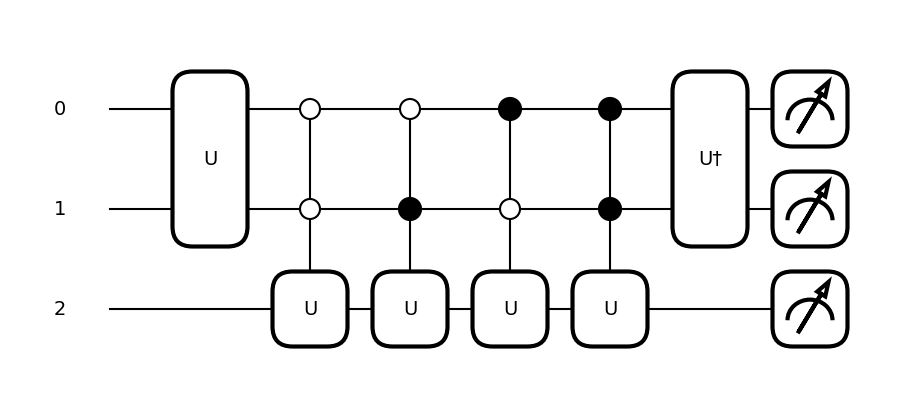

In [11]:
fig, ax = qml.draw_mpl(my_circuit)(0.1)
fig.show()

In [12]:
def error_XandZ(alpha, beta, time):
    """Difference between the exact and Trotterized result.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        n (int): The number of steps in our Trotterization.
        
    Returns: 
        float: The distance between the exact and Trotterized result.
    """
    unnormed = my_circuit(time)[:2] # Unnormalized state of main qubit
    normed = unnormed/np.sqrt(sum(np.conjugate(unnormed)*unnormed)) # Normalize!
    
    #diff = np.abs(my_circuit(time)[:2] - exact_result_XandZ(alpha, beta, time))
    diff = np.abs(normed - exact_result_XandZ(alpha, beta, time))
    return np.sqrt(sum(diff*diff))

In [13]:
dev = qml.device("default.qubit", wires=1)
    
@qml.qnode(dev)
def trotter_XandZ(alpha, beta, time, n):
    """Trotterized circuit for evolving a qubit with H = alpha Z + beta X.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        n (int): The number of steps in our Trotterization.
        
    Returns: 
        array[complex]: The state after applying the Trotterized circuit.
    """
    t = time
    for _ in range(n):
	    qml.PauliRot(2 * t/n * alpha, "Z",wires=0)
	    qml.PauliRot(2 * t/n * beta, "X",wires=0)

    return qml.state()

In [14]:
trotter_XandZ(1, 1, 0.1, 1)

tensor([ 0.99003329-0.09933467j, -0.00996671-0.09933467j], requires_grad=True)

In [15]:
@qml.qnode(dev)
def trotter_2_XandZ(alpha, beta, time, n):
    """Second-order Trotter circuit for the Hamiltonian H = alpha Z +  beta X.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        n (int): The number of steps in our Trotterization.
        
    Returns: 
        array[complex]: The state after applying the second-order circuit.
    """
    t = time
    for _ in range(n):
	    qml.PauliRot(2 * t/(2*n) * alpha, "Z", wires=0)
	    qml.PauliRot(2 * t/(2*n) * beta, "X", wires=0)
	    qml.PauliRot(2 * t/(2*n) * beta, "X", wires=0)
	    qml.PauliRot(2 * t/(2*n) * alpha, "Z", wires=0)

    return qml.state()

def trotter_2_error_XandZ(alpha, beta, time, n):
    """Difference between the exact and second-order Trotter result.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        n (int): The number of steps in our Trotterization.
        
    Returns: 
        float: The distance between the exact and second-order result.
    """
    diff = np.abs(trotter_2_XandZ(alpha, beta, time, n) - exact_result_XandZ(alpha, beta, time))
    return np.sqrt(sum(diff*diff))

In [48]:
@qml.qnode(dev)
def trotter_3_XandZ(alpha, beta, time, n):
    """Third-order Trotter circuit for the Hamiltonian H = alpha Z + beta X.

    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        n (int): The number of steps in our Trotterization.

    Returns:
        array[complex]: The state after applying the third-order circuit.
    """
    # Coefficients for the third-order Trotter-Suzuki decomposition
    a1 = 1.3512071919596578
    a2 = -1.7024143839193153
    a3 = 1.3512071919596578

    b1 = 0.5
    b2 = 0.5

    t = time

    for _ in range(n):
        qml.PauliRot(2 * t / n * a1 * alpha, "Z", wires=0)
        qml.PauliRot(2 * t / n * b1 * beta, "X", wires=0)
        qml.PauliRot(2 * t / n * a2 * alpha, "Z", wires=0)
        qml.PauliRot(2 * t / n * b2 * beta, "X", wires=0)
        qml.PauliRot(2 * t / n * a3 * alpha, "Z", wires=0)

    return qml.state()

def trotter_3_error_XandZ(alpha, beta, time, n):
    """Difference between the exact and second-order Trotter result.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        n (int): The number of steps in our Trotterization.
        
    Returns: 
        float: The distance between the exact and second-order result.
    """
    diff = np.abs(trotter_3_XandZ(alpha, beta, time, n) - exact_result_XandZ(alpha, beta, time))
    return np.sqrt(sum(diff*diff))

In [49]:
def trotter_error_XandZ(alpha, beta, time, n):
    """Difference between the exact and Trotterized result.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        n (int): The number of steps in our Trotterization.
        
    Returns: 
        float: The distance between the exact and Trotterized result.
    """
    diff = np.abs(trotter_XandZ(alpha, beta, time, n) - exact_result_XandZ(alpha, beta, time))
    return np.sqrt(sum(diff*diff))

In [17]:
def truncation_XandZ(alpha, beta, time, K_bits):
    """
    Generates unitaries and coefficients for the truncated X and Z evolution.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        K_bits (int): The index of the truncation order, K = 2^K_bits.
        
    Returns: 
        [array[complex], array[array(complex)]]: Coefficients and unitaries.
    """
    root = np.sqrt(alpha**2 + beta**2)
    coeff_list = [0]*2**K_bits
    U_list = [0]*2**K_bits
    V = (alpha*qml.PauliZ(wires=0).compute_matrix() + beta*qml.PauliX(wires=0).compute_matrix())/root

    for k in range(2**(K_bits-1)):
        
        coeff_list[2*k] = ((time * np.sqrt(alpha**2 + beta**2))**(2*k))/(fact(2*k)) # MODIFY THIS
        coeff_list[2*k + 1] = ((time * np.sqrt(alpha**2 + beta**2))**(2*k + 1)) / (fact(2 * k +1)) # MODIFY THIS
        U_list[2*k] = np.eye(2) * (-1)**k 
        U_list[2*k + 1] = (-1)**k * (-1j) * V 

    return [coeff_list, U_list]


In [39]:
def LCU_XandZ(alpha, beta, time, K_bits):
    """
    LCU circuit for simulating the Hamiltonian H = alpha Z + beta X.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        K_bits (int): The index of the truncation order, K = 2^K_bits.
        
    Returns: 
        array[complex]: The state after applying the LCU circuit.
    """
    aux = range(K_bits) # The auxiliary qubits
    main = range(K_bits, K_bits + 1) # The main system
    dev2 = qml.device("default.qubit", wires=K_bits + 1, shots=None)
    [coeff_list, U_list] = truncation_XandZ(alpha, beta, time, K_bits)
    
    @qml.qnode(dev2)
    def LCU_circuit():
        print(PREPARE(coeff_list))
        qml.QubitUnitary(PREPARE(coeff_list),wires=aux)
        SELECT(U_list)
        qml.QubitUnitary(PREPARE(coeff_list).conj().T, wires=aux)
        #TEST: Apply twice!
        #qml.QubitUnitary(PREPARE(coeff_list),wires=aux)
        #SELECT(U_list)
        #qml.QubitUnitary(PREPARE(coeff_list).conj().T, wires=aux)

        return qml.state()
    
    #fig, ax = qml.draw_mpl(LCU_circuit)()
    #fig.show()

    #unnormed = LCU_circuit()[:2] # Unnormalized state of main qubit
    #normed = unnormed/np.sqrt(sum(np.conjugate(unnormed)*unnormed)) # Normalize!
    
    return LCU_circuit()[:2]#normed


In [40]:
def LCU_error_XandZ(alpha, beta, time, K_bits):
    """
    Difference between the exact and LCU simulation result.
    
    Args:
        alpha (float): The coefficient of Z in the Hamiltonian.
        beta (float): The coefficient of X in the Hamiltonian.
        time (float): The time we evolve the state for.
        K_bits (int): The index of the truncation order, K = 2^K_bits.
        
    Returns: 
        float: The distance between the exact and LCU result.
    """

    diff = np.abs(LCU_XandZ(alpha, beta, time, K_bits) - exact_result_XandZ(alpha, beta,time)) 
    #diff = np.abs(LCU_XandZ(alpha, beta, time/2., K_bits) - exact_result_XandZ(alpha, beta,time)) 

    return np.sqrt(sum(diff*diff))

In [41]:
LCU_error_XandZ(1,1,0.1,2)

[[ 0.99868412  0.04948452  0.01315867  0.00285699]
 [ 0.04948452 -0.86089592 -0.49483976 -0.10743888]
 [ 0.01315867 -0.49483976  0.86841479 -0.02856959]
 [ 0.00285699 -0.10743888 -0.02856959  0.99379701]]


tensor(0.13869585, requires_grad=True)

/var/folders/0h/11cl6yyx6416byc76nf38wk82045kc/T/ipykernel_21636/3827284791.py:21: RuntimeWarning: invalid value encountered in divide
  return householder((zero_vec - alpha_list) / np.linalg.norm(zero_vec -alpha_list))


[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[[ 0.99868412  0.04948452  0.01315867  0.00285699]
 [ 0.04948452 -0.86089592 -0.49483976 -0.10743888]
 [ 0.01315867 -0.49483976  0.86841479 -0.02856959]
 [ 0.00285699 -0.10743888 -0.02856959  0.99379701]]
[[ 0.99024694  0.12965192  0.04875694  0.01497091]
 [ 0.12965192 -0.72352359 -0.64814881 -0.19901536]
 [ 0.04875694 -0.64814881  0.75625696 -0.07484178]
 [ 0.01497091 -0.19901536 -0.07484178  0.97701969]]
[[ 0.96967558  0.21928542  0.10099802  0.03798135]
 [ 0.21928542 -0.58572158 -0.73034837 -0.27465503]
 [ 0.10099802 -0.73034837  0.66361765 -0.12650005]
 [ 0.03798135 -0.27465503 -0.12650005  0.95242835]]
[[ 0.93417015  0.30869311  0.16417213  0.07128962]
 [ 0.30869311 -0.4475414  -0.76984535 -0.33429537]
 [ 0.16417213 -0.76984535  0.59057346 -0.17778817]
 [ 0.07128962 -0.33429537 -0.17778817  0.92279779]]
[[ 0.88288672  0.3917454   0.23293321  0.11308716]
 [ 0.3917454  -0.31039329 -0.77916451 -0.37827796]
 

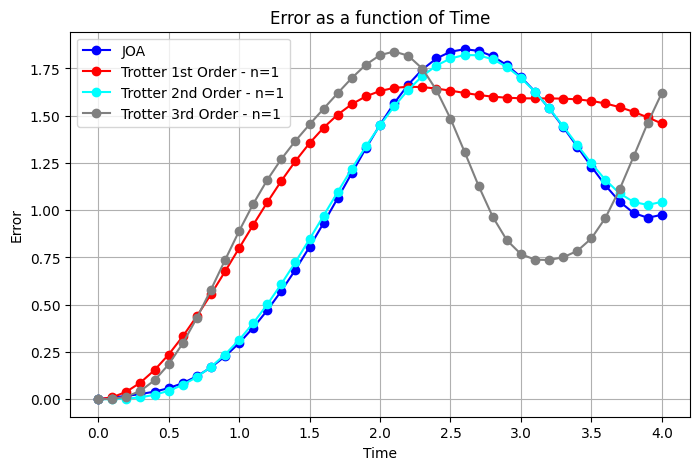

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define your parameters
alpha = 1.  # Example value for alpha
beta = 1.   # Example value for beta

# Define time values from 0 to 1 in intervals of 0.1
time_values = np.arange(0, 4.1, 0.1)

# Compute error for each time value
errors = [error_XandZ(alpha, beta, time) for time in time_values]
error_trotter1 = [trotter_error_XandZ(alpha, beta, time, 1) for time in time_values]
error_trotter1_2 = [trotter_error_XandZ(alpha, beta, time, 2) for time in time_values]
error_trotter1_3 = [trotter_error_XandZ(alpha, beta, time, 3) for time in time_values]
error_trotter2 = [trotter_2_error_XandZ(alpha, beta, time, 1) for time in time_values]
error_trotter2_2 = [trotter_2_error_XandZ(alpha, beta, time, 2) for time in time_values]
error_LCU = [LCU_error_XandZ(alpha, beta, time, 2) for time in time_values]
error_trotter3 = [trotter_3_error_XandZ(alpha, beta, time, 1) for time in time_values]


# Plotting
plt.figure(figsize=(8, 5))
plt.plot(time_values, errors, marker='o', linestyle='-', color='b', label = 'JOA')
plt.plot(time_values, error_trotter1, marker='o', linestyle='-', color='r', label='Trotter 1st Order - n=1')
#plt.plot(time_values, error_trotter1_2, marker='o', linestyle='--', color='black', label='Trotter 1st Order - n=2')
#plt.plot(time_values, error_trotter1_3, marker='o', linestyle='--', color='orange', label='Trotter 1st Order - n=3')
plt.plot(time_values, error_trotter2, marker='o', linestyle='-', color='cyan', label='Trotter 2nd Order - n=1')
plt.plot(time_values, error_trotter3, marker='o', linestyle='-', color='gray', label='Trotter 3rd Order - n=1')
#plt.plot(time_values, error_LCU, marker='o', linestyle='-', color='g', label= 'LCU')
plt.xlabel('Time')
plt.ylabel('Error')
#plt.yscale('log')
plt.title('Error as a function of Time')
plt.grid(True)
plt.legend()
plt.show()
